#### Objective : Univariate Time Series Modelling using DARTS for model training and weight & Biases for model logging to beat the becnhmark model already provided

#### Created By : Ashwini Kumar

#### Start Date : 16th March 2022

#### Steps Involved :

    1. Read the data from the csv file and split into train and validation splits 
    
    2. Define the Variables to be tuned and define the error function for benchmarking
    
    3. Define the Weight & Bias Initialization using API Key
    
    4. Use Sweep to do hyperparam tuning in the data
    
    5. Log the data to Weight & Bias to see the results

In [198]:
# Import the required packages 
# Import the required packages 
from darts import TimeSeries
import pandas as pd
import tqdm as notebook_tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import wandb ## Function for weights and biases
import plotly
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel,NBEATSModel,TransformerModel,AutoARIMA,TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import TCNModel, RNNModel
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Prophet, Theta
import os
# Remove Noise using the Gaussian Wave
from darts.models.forecasting.regression_ensemble_model import RegressionEnsembleModel
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF
from darts.models import GaussianProcessFilter
import matplotlib.pyplot as plt
# from darts import ModelMode
from darts.utils.utils import SeasonalityMode,ModelMode

In [199]:
# Function to read the csv file from given location & parse datetime properly
def load_dataframe(filename):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

# Function create the Time Series from Dataframe using a Time Series to df function
def df_to_timeseries(df,time_column, timeseries):
    series = TimeSeries.from_dataframe(df, time_column,timeseries)
    return (series)

# Define the Mean Absolute Error for evaluating our model
from darts.metrics import mae
def eval_error(actual_values,pred_values):
    return mae(actual_values,pred_values)

# Call the function to read the data properly

df = load_dataframe("C:\\Users\\ashwini.kumar\\Time_Series_Modelling\\_Final_master_df_2022_2017_v9_with_Bolzano.csv")
df.head(5)


,Date,RequestedQTY,GoodsIssuedQTY,InvoicedQTY,PDO number,req_Illy,req_Teddy,req_Thun,req_other,inv_Illy,...,BOL_B2B AA Thun,BOL_B2B P&P Thun,BOL_B2B Sorter Thun,BOL_B2B Sorter SM Thun,BOL_B2B Sorter BVB Thun,BOL_B2B Sorter riassortimenti WHS,BOL_B2C Thun,BOL_B2C Sorter Thun,BOL_B2C P2L Thun,BOL_Inbound Thun
0,2016-12-26,1616.0,1613.0,1613.0,135,635.0,0.0,981.0,0.0,635.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,227928.0,217034.0,216049.0,12075,12851.0,0.0,215041.0,36.0,11866.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-09,176524.0,167839.0,166669.0,10663,14442.0,0.0,162078.0,4.0,13272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-16,289548.0,280089.0,279048.0,12330,14555.0,0.0,274961.0,32.0,13514.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-23,248337.0,234044.0,232787.0,15942,15244.0,0.0,233063.0,30.0,13987.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
help(df_to_timeseries)

Help on function df_to_timeseries in module __main__:

df_to_timeseries(df, time_column, timeseries)
    # Function create the Time Series from Dataframe using a Time Series to df function



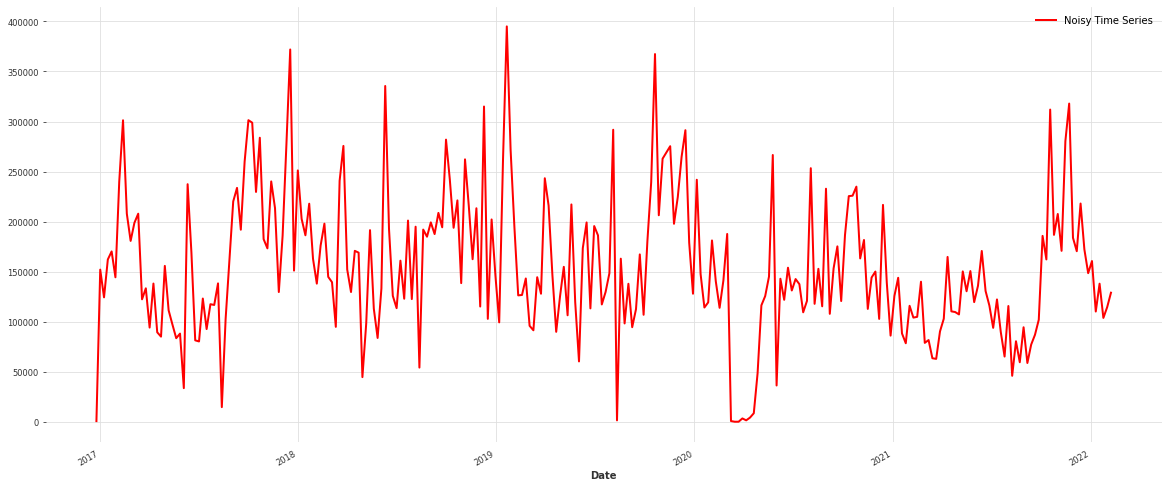

In [216]:
# Use the ThunB2B sorter values and split
timeseries_input = df_to_timeseries(df,"Date","req_ThunB2B_Sorter")

benchmark_input = df_to_timeseries(df,"Date","BOL_B2B Sorter Thun")

# Set aside the data since 2021 
train_data, val_data = timeseries_input.split_before(pd.Timestamp('2021-01-04'))

train_benchmark_ignore, benchmark_data = benchmark_input.split_before(pd.Timestamp('2021-01-04'))

timeseries_input.plot(color="red", label="Noisy Time Series")
    
plt.legend()

In [217]:
from darts.metrics import mae
def eval_error(actual_values,pred_values):
    return mae(actual_values,pred_values)

Running for  req_ThunB2B_Sorter


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Call the training function


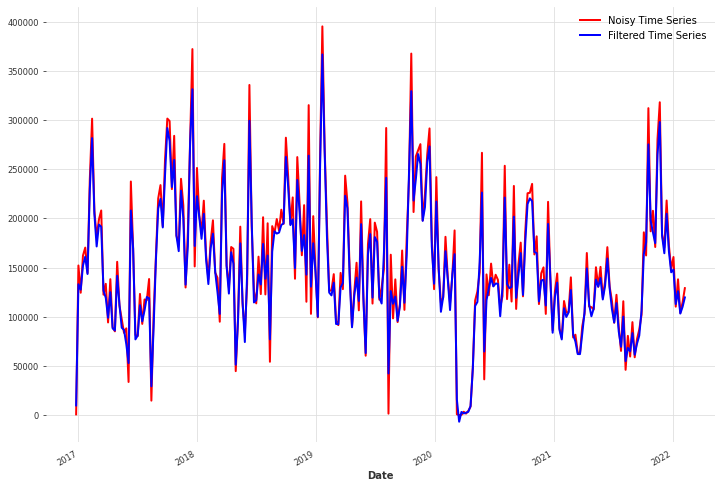

In [218]:


# The function to define the train_data input data and other functions
def call_timeseries(train_column,benchmark_column):
    timeseries_input = df_to_timeseries(df,"Date",train_column)
#     print (timeseries_input)

    benchmark_input = df_to_timeseries(df,"Date",benchmark_column)
    # Set aside the data since 2021 
    
    kernel = ExpSineSquared()
    # kernel = RBF()

    gpf = GaussianProcessFilter( kernel=kernel, alpha=0.2 / 2, n_restarts_optimizer=100)
    
    filtered_x = gpf.filter(df_to_timeseries(df,"Date",train_column))
                            
    plt.figure(figsize=[12, 8])
    timeseries_input.plot(color="red", label="Noisy Time Series")
    filtered_x.plot(color="blue", label="Filtered Time Series")
    plt.legend()
#     plt.savefig(series_name + 'filtered' + "/" + train_column + '.png')

    train_data , val_data_filtered = filtered_x.split_before(pd.Timestamp('2021-01-04'))

    train_data_noisy, val_data = timeseries_input.split_before(pd.Timestamp('2021-01-04'))

    train_benchmark_ignore, benchmark_data = benchmark_input.split_before(pd.Timestamp('2021-01-04'))
    
    return train_data,val_data,benchmark_data,timeseries_input


train_series = ["req_ThunB2B_Sorter"]
benchmark_series = ["BOL_B2B Sorter Thun"]

# train_series = ['Sum_All_Variables' ]
# benchmark_series = ['Sum_All_Variables_Benchmark']


for i in range(len(train_series)):
    
    print ("Running for " , train_series[i])
    train_data,val_data,benchmark_data,timeseries_input = call_timeseries(train_series[i],benchmark_series[i])
    print ("Call the training function")


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Benchmark Loss is : 33980.206896551725
Model Predict Loss is : 51171.38135552206


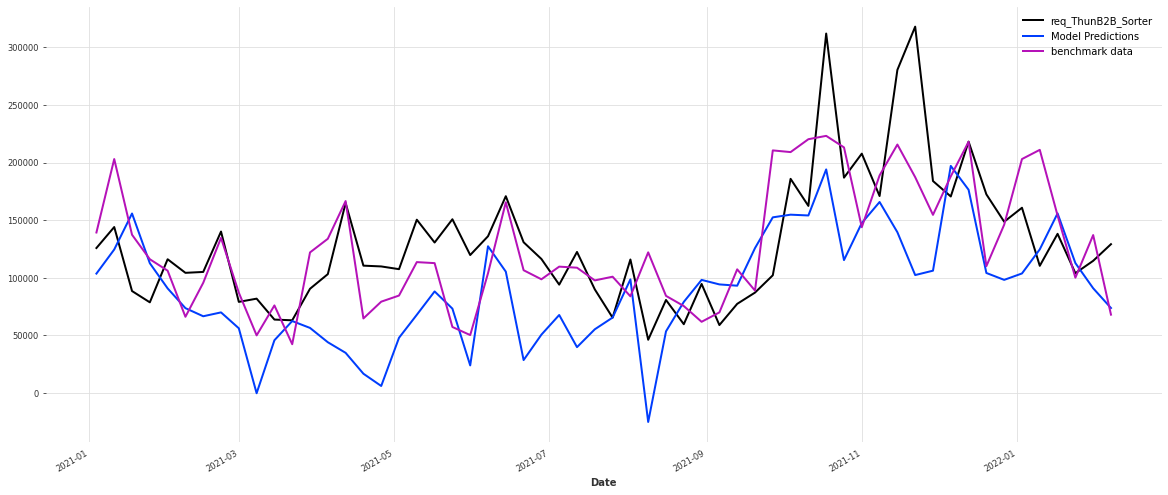

In [219]:
# model = RegressionEnsembleModel([ Prophet(),Prophet(n_changepoints = 5, changepoint_range = .95),
#                               Prophet(n_changepoints = 10, changepoint_range = .95)  ],regression_train_n_points=12)
# print ("Fitting the Model with Deafults Params :",mo,del_type)
# Fit the model on training dat
model=ExponentialSmoothing(trend = ModelMode.ADDITIVE,damped=True, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=52)
model_req = model.fit(train_data)
#Make the prediction for 58 observation on train Data
pred_air = model_req.predict(n = 58)

#             print (pred_air)
# Predict the data for Backtesting
#             if num <= 4:
#                 pred_backtest = model.historical_forecasts(timeseries_input,
#                   start=pd.Timestamp("2020-12-28"),  forecast_horizon=4)
#             else:
#                 pred_backtest = model.historical_forecasts(timeseries_input,
#                   start=pd.Timestamp("2020-12-28"),  forecast_horizon=8, retrain=False)
#             print (pred_backtest)
#             print (len(pred_backtest))
# Calculate the loss off model
loss_model = mae(val_data , pred_air)
#Calculate the loss of bencmark model
loss_benchmark = mae(val_data, benchmark_data)
# Calculate the loss off backtesting
#             loss_backtesting = mae(val_data,pred_backtest)
# Print the loss function for benchmark data
print ("Benchmark Loss is :", loss_benchmark) 
# Print the loss function for benchmark data
print ("Model Predict Loss is :", loss_model)      
# Print the loss function for benchmark data
#             print ("Model Backtest Loss is :", loss_backtesting)  

# Initialize the plotting variables


# Set the image size
plt.rcParams["figure.figsize"] = (20,8)
# Plot the actual time series data
val_data.plot()
# Plot the prediction made
pred_air.plot(label='Model Predictions', low_quantile=0.05, high_quantile=0.95)
benchmark_data.plot(label='benchmark data', low_quantile=0.05, high_quantile=0.95)
#             pred_backtest.plot(label='Backtesting Predictions', low_quantile=0.05, high_quantile=0.95)
plt.legend()



In [220]:
## Lets Initialise the weight & biases and tune the hyperparams for Nbeats model to see how it performs

In [221]:
!pip install wandb -qqq
!pip install plotly
import wandb
import plotly

In [222]:
# Login to Weight & Biases 
wandb.login()

True

In [223]:
# Define SWEEP function in DARTS and record all the hyperparams
wandb.init(project="TimeSeries-req_ThunB2C_Sorter", entity="fibonacciash")
sweep_config = {
  "name" : "my-sweep",
  "method" : "grid",
  "parameters" : {
#       "trend" : {"values" :[ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE,ModelMode.NONE]},
    "damped" :{"values" : [True,False]},
#      "seasonal":{"values":[SeasonalityMode.ADDITIVE, SeasonalityMode.MULTIPLICATIVE, SeasonalityMode.NONE]},
    "seasonal_periods" :{"values":[4,8,16,24,32,52,53,56,60,72]} 
       }        }
      ## For prophet
#       "seasonality_mode" : {"values":['additive','multiplicative']},
#       "n_changepoints" : {"values" : [5,10,20,30,40,50,60,70,80]},
#       "changepoint_range" : {"values" : [0.5,0.6,0.7,0.8,0.9]},
#       "seasonality_prior_scale" : {"values" :[5,10,20,30,40,50]}
            


sweep_id = wandb.sweep(sweep_config)
import pprint
pprint.pprint(sweep_config)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Create sweep with ID: pkjlu0cg
Sweep URL: https://wandb.ai/fibonacciash/uncategorized/sweeps/pkjlu0cg
{'method': 'grid',
 'name': 'my-sweep',
 'parameters': {'damped': {'values': [True, False]},
                'seasonal_periods': {'values': [4,
                                                8,
                                                16,
                                                24,
                                                32,
                                                52,
                                                53,
                                                56,
                                                60,
                                                72]}}}


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: m1z0e2vv with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 4


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,42064.08945


wandb: Agent Starting Run: ua2sbdpt with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 8


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,44302.18641


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a7wo9k15 with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 16


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,44375.55239


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: edsm6rz4 with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 24


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,59947.20588


wandb: Agent Starting Run: w1g6y0gj with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 32


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,47384.44712


wandb: Agent Starting Run: j10bsmpg with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 52


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,51171.38136


wandb: Agent Starting Run: 5ml1rxpc with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 53


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,51071.40127


wandb: Agent Starting Run: 37wrlwhe with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 56


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,86334.26135


wandb: Agent Starting Run: utq9ju6c with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 60


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,78480.38992


wandb: Agent Starting Run: p8pu2zxx with config:
wandb: 	damped: True
wandb: 	seasonal_periods: 72


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,49126.83355


wandb: Agent Starting Run: fbvlj1yk with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 4


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,45947.73298


wandb: Agent Starting Run: j0z2uo8s with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 8


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,141434.52524


wandb: Agent Starting Run: hbme4dqv with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 16


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,133799.51683


wandb: Agent Starting Run: 8333yhp6 with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 24


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,128722.47125


wandb: Agent Starting Run: ttw0inym with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 32


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,48723.52254


wandb: Agent Starting Run: 6dpdjw9v with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 52


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,50276.05597


wandb: Agent Starting Run: er1iuzo4 with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 53


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,48179.56406


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1vjttbgk with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 56


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,93054.07712


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4281c7c5 with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 60


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,80686.83309


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 26ltgyg3 with config:
wandb: 	damped: False
wandb: 	seasonal_periods: 72


C:\Users\ashwini.kumar\source\repos\anaconda3\envs\practice\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


loss_benchmark,▁
loss_train,▁
loss_benchmark,33980.2069
loss_train,48594.72468


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


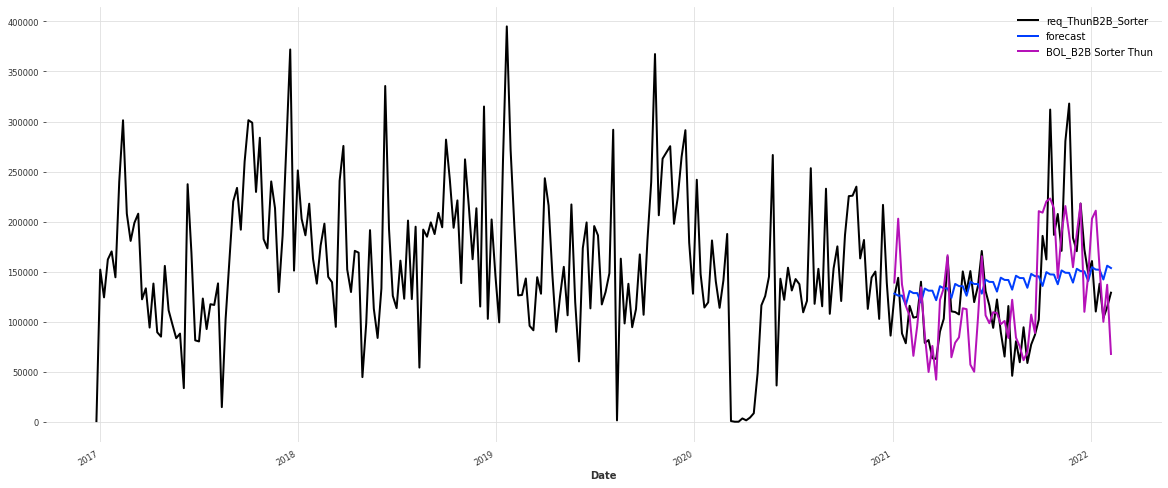

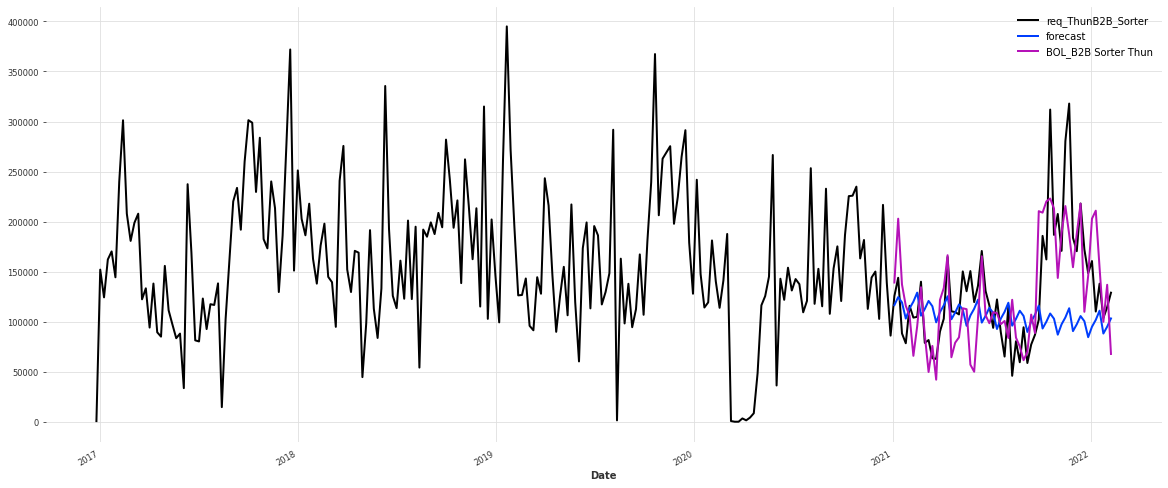

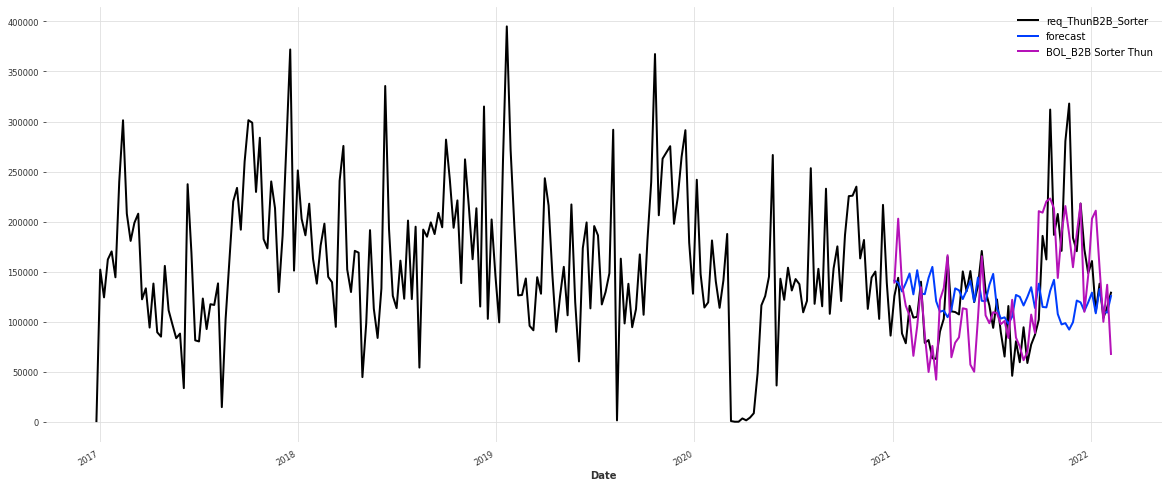

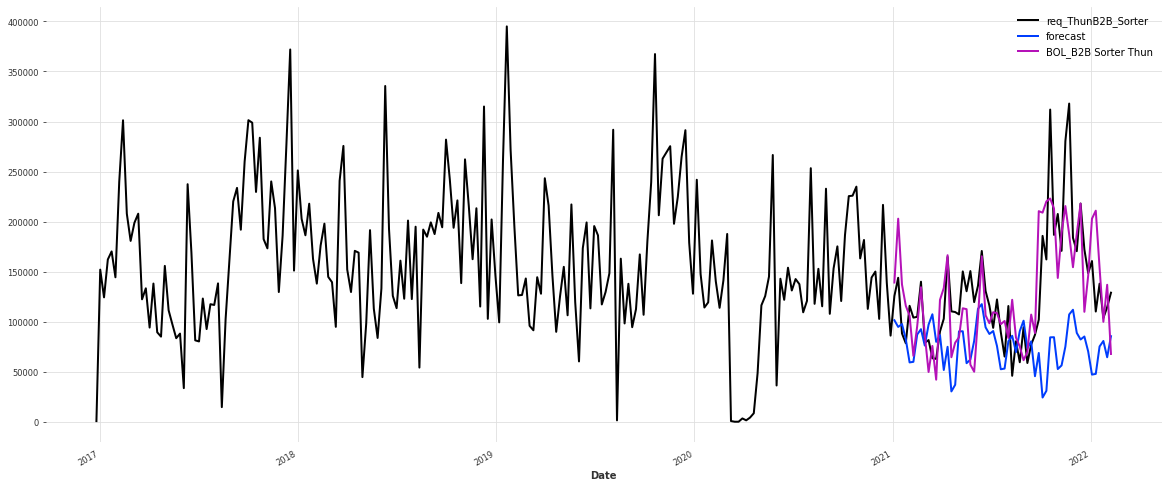

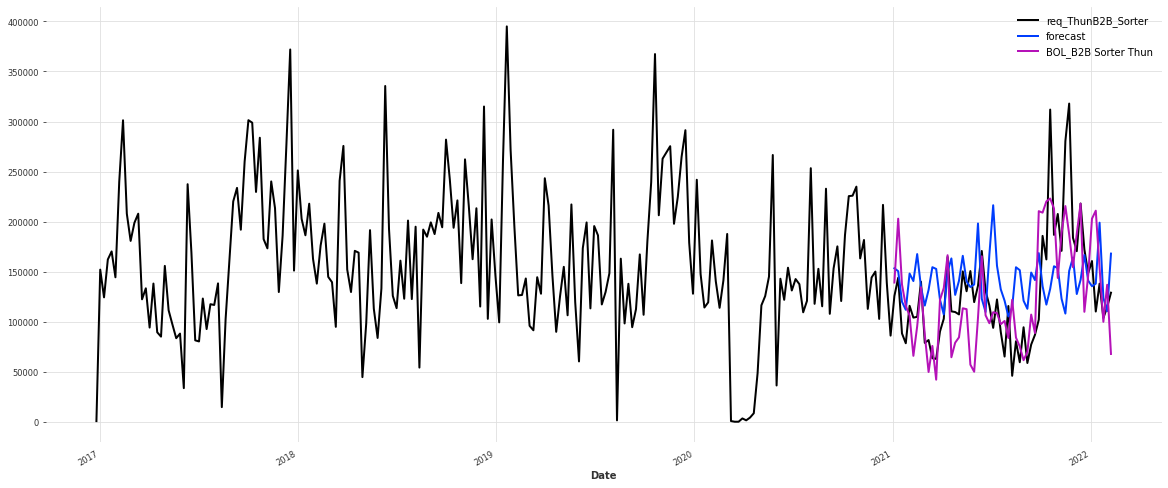

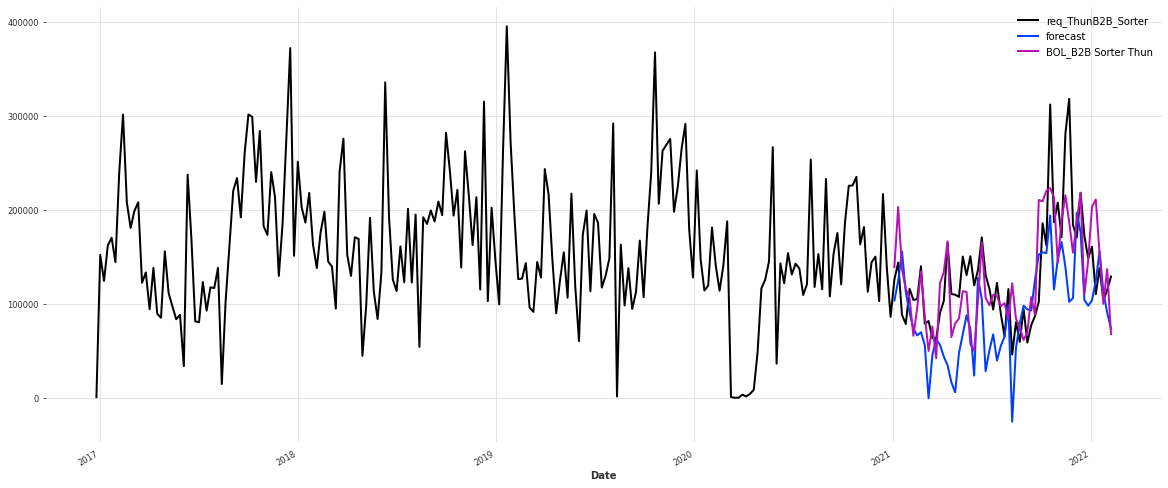

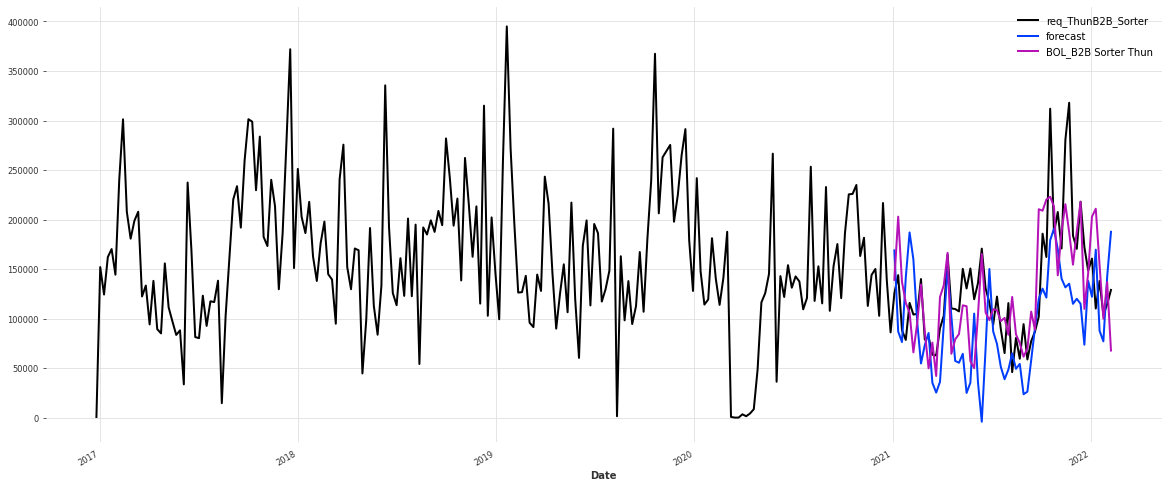

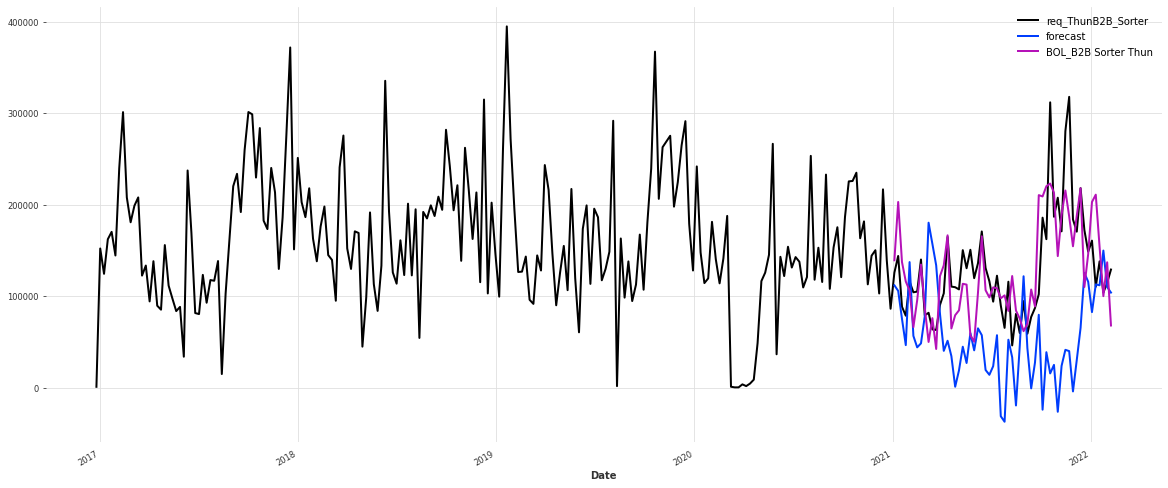

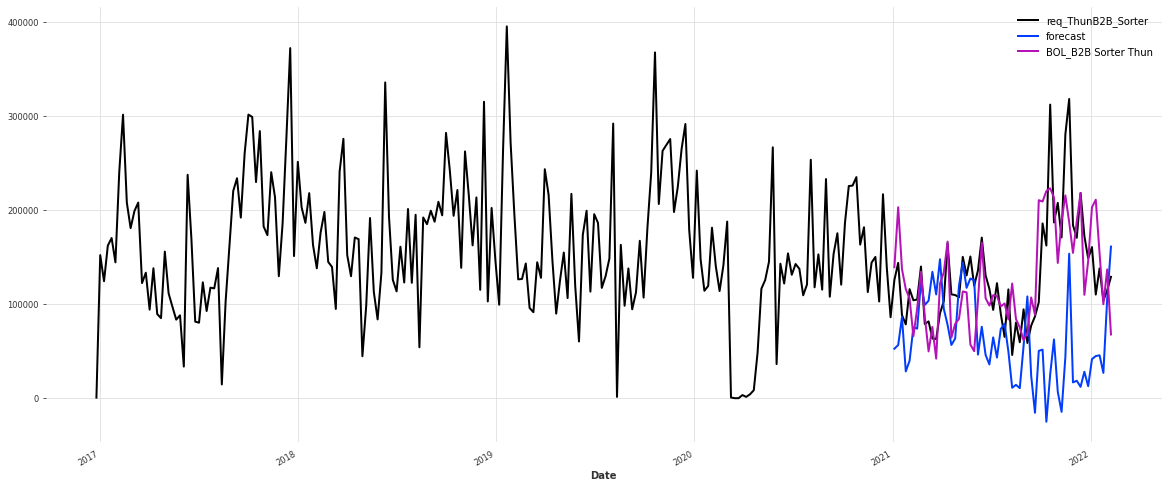

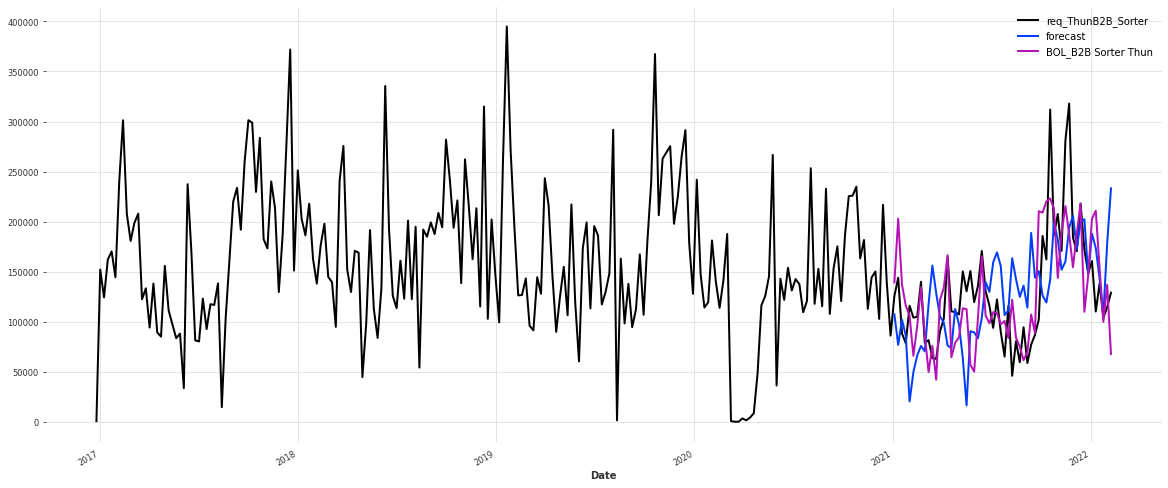

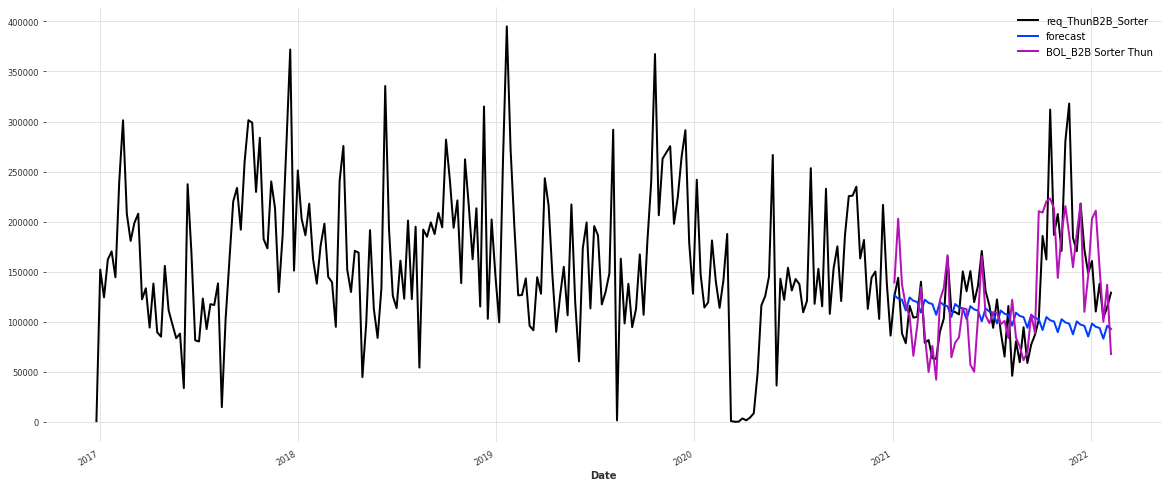

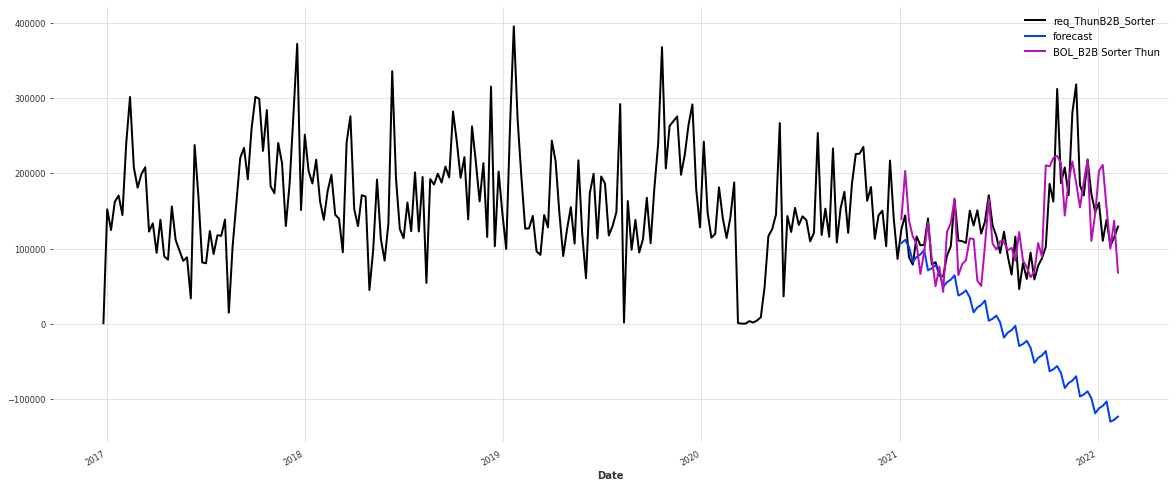

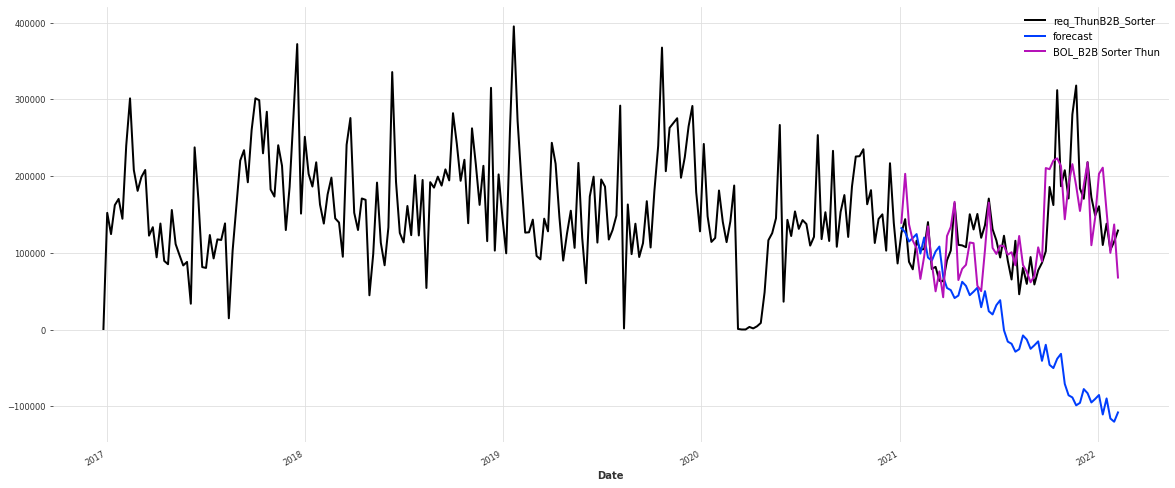

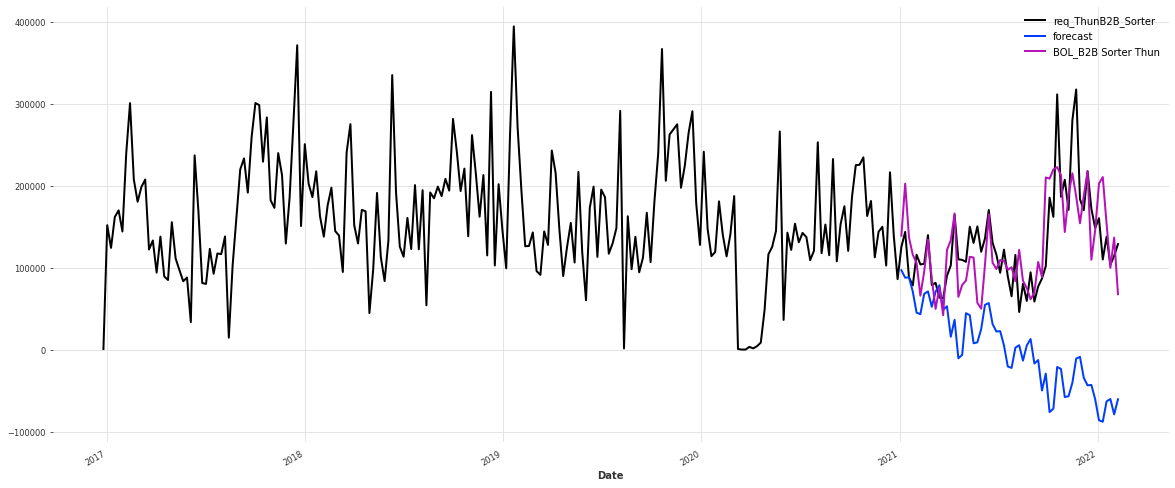

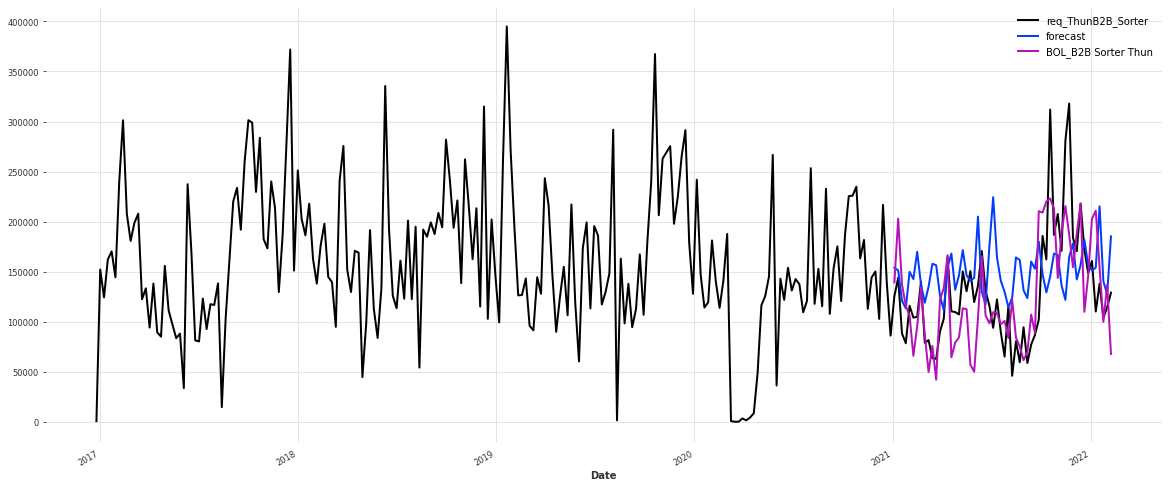

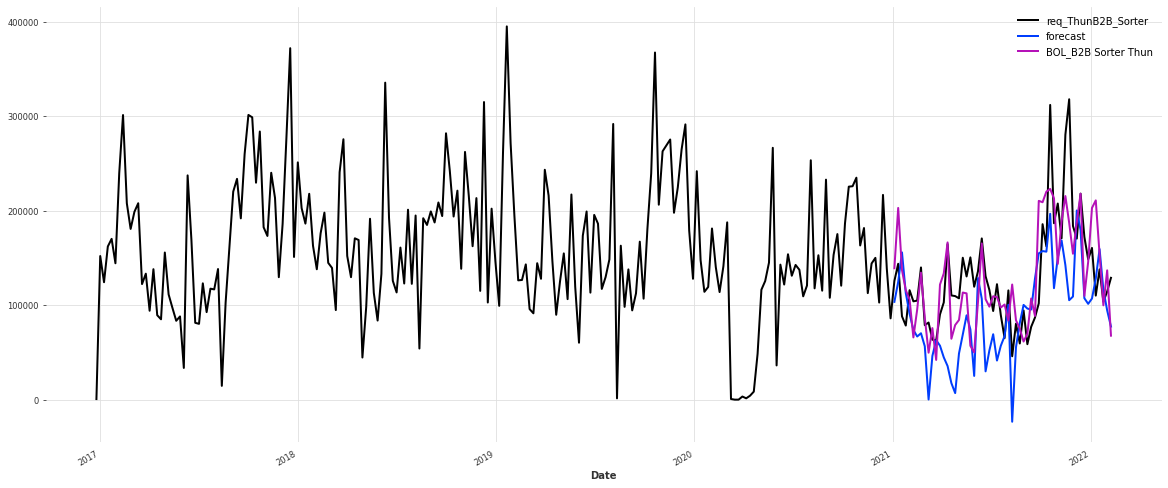

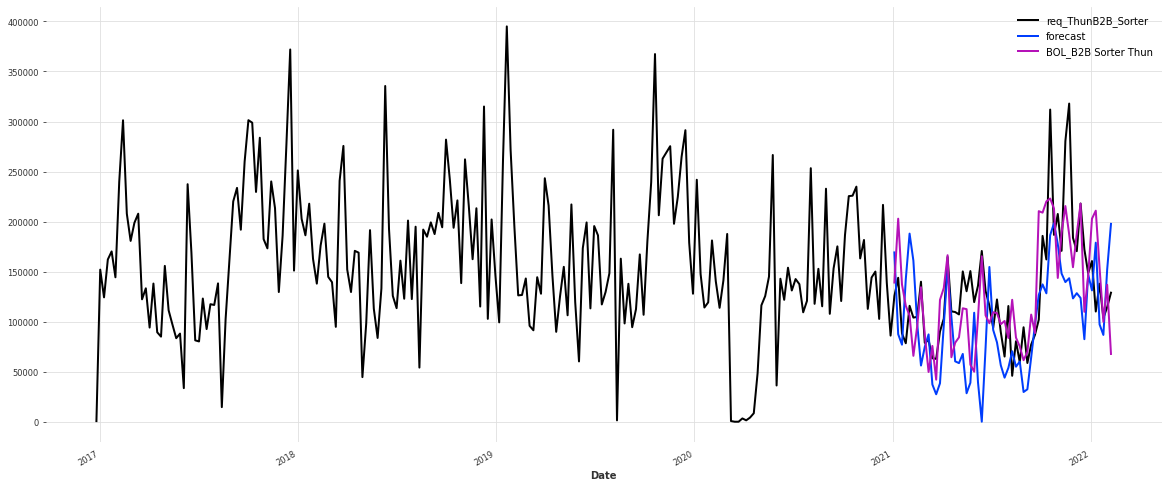

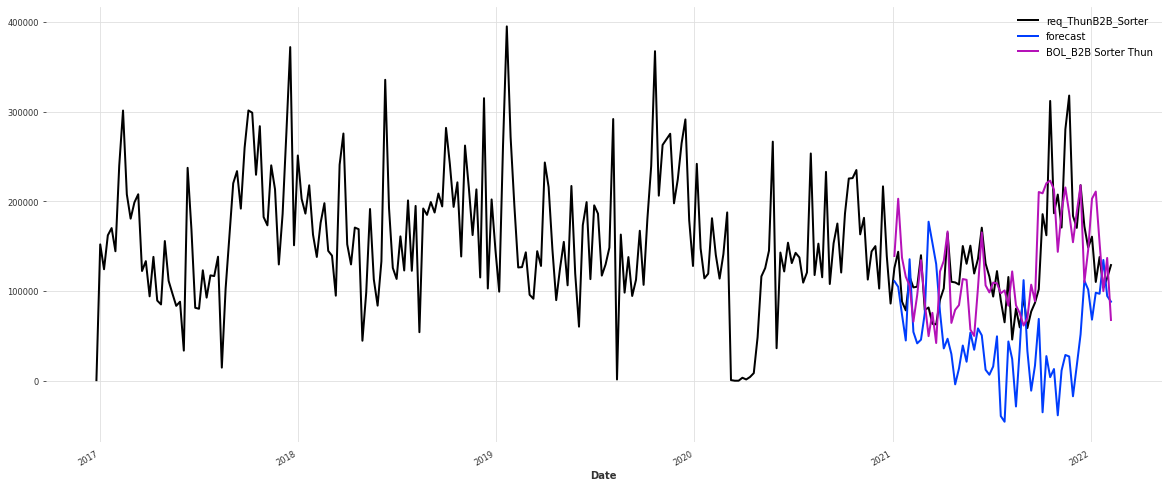

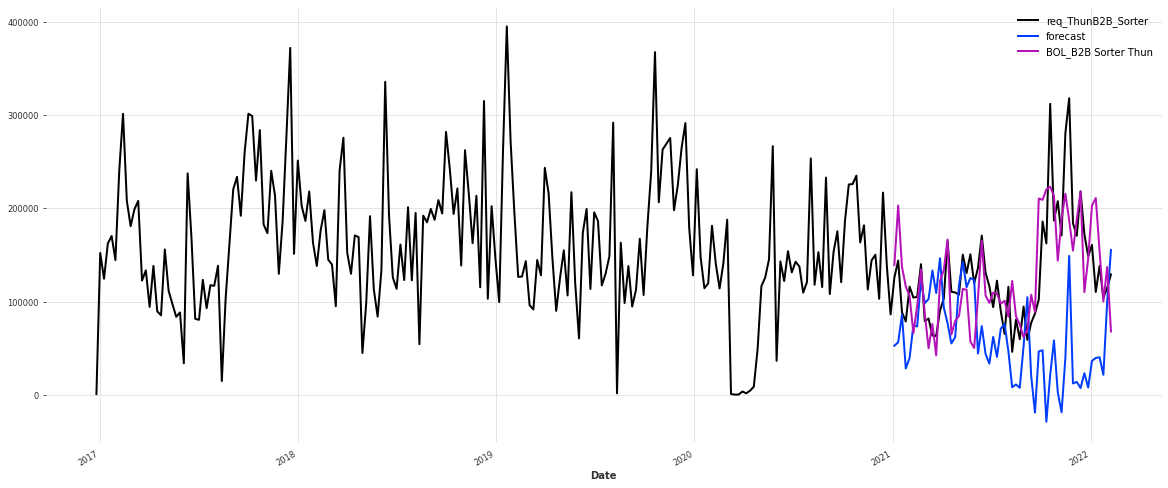

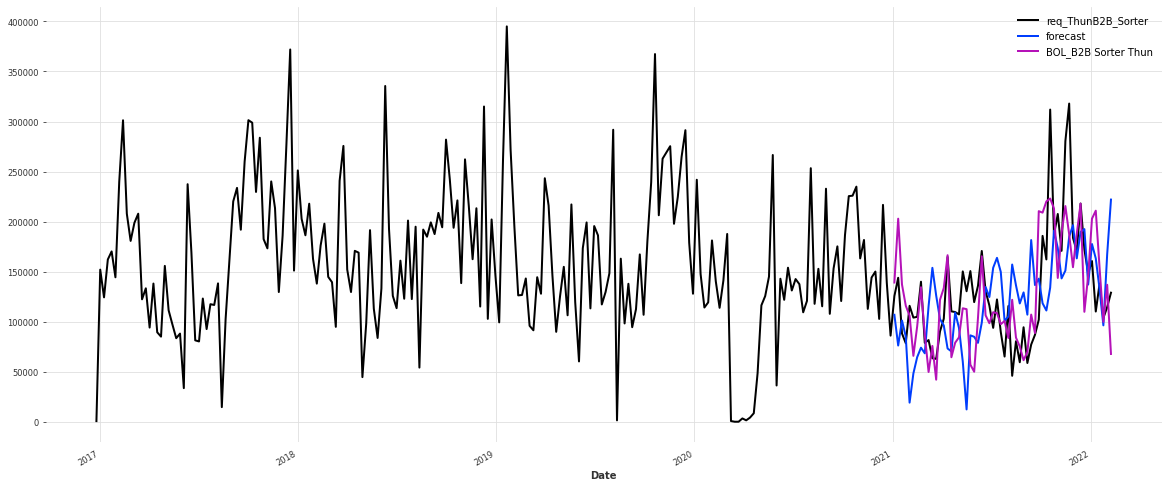

In [224]:
wandb.init(project="TimeSeries-req_ThunB2C_Sorter", entity="fibonacciash")
def train():
    with wandb.init() as run:
        config = wandb.config

       
 # your model training code here

  
        model = ExponentialSmoothing(damped=config.damped, 
                                      seasonal_periods=config.seasonal_periods)
        # fitting the model
        model_req = model.fit(train_data)

        pred_air = model_req.predict(n = 58)


        loss = mae(val_data , pred_air)

        loss_benchmark = mae(val_data, benchmark_data)
        ## Log the absolute Error
        wandb.log({"loss_train": loss})  
        ## 
        wandb.log({"loss_benchmark": loss_benchmark})  
        plt.figure()
        plt.rcParams["figure.figsize"] = (20,8)
        timeseries_input.plot()
        model.predict(n = 58).plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
        benchmark_data.plot()
        plt.legend()
        plot_image = wandb.Image(plt)
        wandb.log({"chart" : plot_image})

count = 30 # number of runs to execute
wandb.agent(sweep_id, function=train)